###**Chris Smith, Omari Emmanuel and Hanna Nguyen**

In [1]:
#importing packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

file_1 = "/content/gender_submission.csv"
df=pd.read_csv(file_1)

df2 = pd.read_csv("/content/test.csv")
print(df['PassengerId'].head())
print(df2['PassengerId'].head())  # if predictions is a DataFrame

# cant use train file innacurate passengerID

titanic = pd.merge(df, df2, on="PassengerId")
print(titanic.head())
print(titanic.info())
print(titanic.index)

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64
0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64
   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   31

<Axes: xlabel='Survived', ylabel='count'>

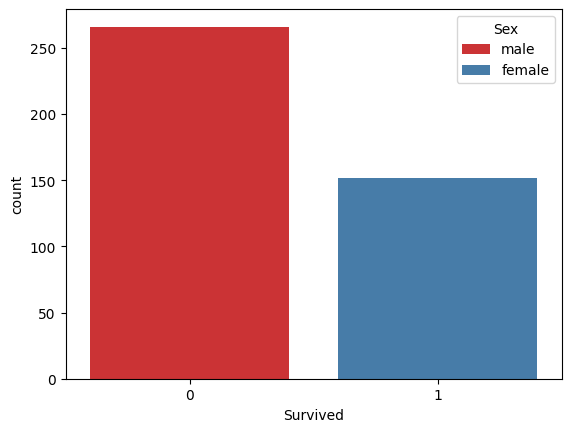

In [2]:
import seaborn as sns
sns.countplot(x="Survived", hue="Sex", data=titanic, palette="Set1")
#0 = no survival, 1 = survived

In [4]:
#preprocess data
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Fare'].fillna(titanic['Fare'].median(), inplace=True)
features = ['Sex', 'Age',"SibSp","Fare",'Parch'] #inputs
df = titanic[features]

X = df[features]
y = titanic['Survived'] #target variable


<ipython-input-4-cb50475c20b5>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
<ipython-input-4-cb50475c20b5>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

##Random Forest Model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[45  5]
 [23 11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.90      0.76        50
           1       0.69      0.32      0.44        34

    accuracy                           0.67        84
   macro avg       0.67      0.61      0.60        84
weighted avg       0.67      0.67      0.63        84



## Model Attempt 1: Random Forest Classifier (Initial Attempt)
- Parameters: `n_estimators=500, max_depth=10, max_leaf_nodes=100`
- Features used: `Sex`, `Age`, `SibSp`, `Fare`, `Parch`
- Reason for choosing these parameters: Default reasonable assumptions based on prior knowledge.

**Overall Accuracy:** 67%

**Interpretation:**
- **Precision:**  
  - The model correctly predicted survival about 69% of the time, and correctly predicted non-survival about 66% of the time.
- **Recall:**  
  - The model accurately identified 90% of passengers who did not survive. However, it only captured 32% of actual survivors, which indicates a critical limitation.
- **Conclusion:**  
  - While this Random Forest model provided a reasonable initial baseline, its low recall for survivors (32%) indicates significant room for improvement, justifying further tuning and exploration of other models.

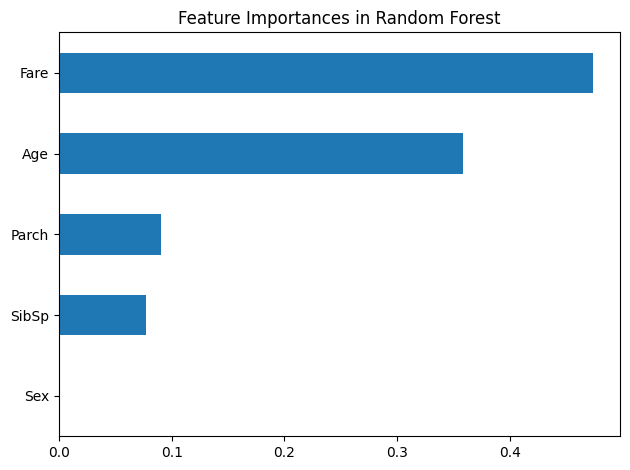

In [6]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances in Random Forest")
plt.tight_layout()
plt.show()

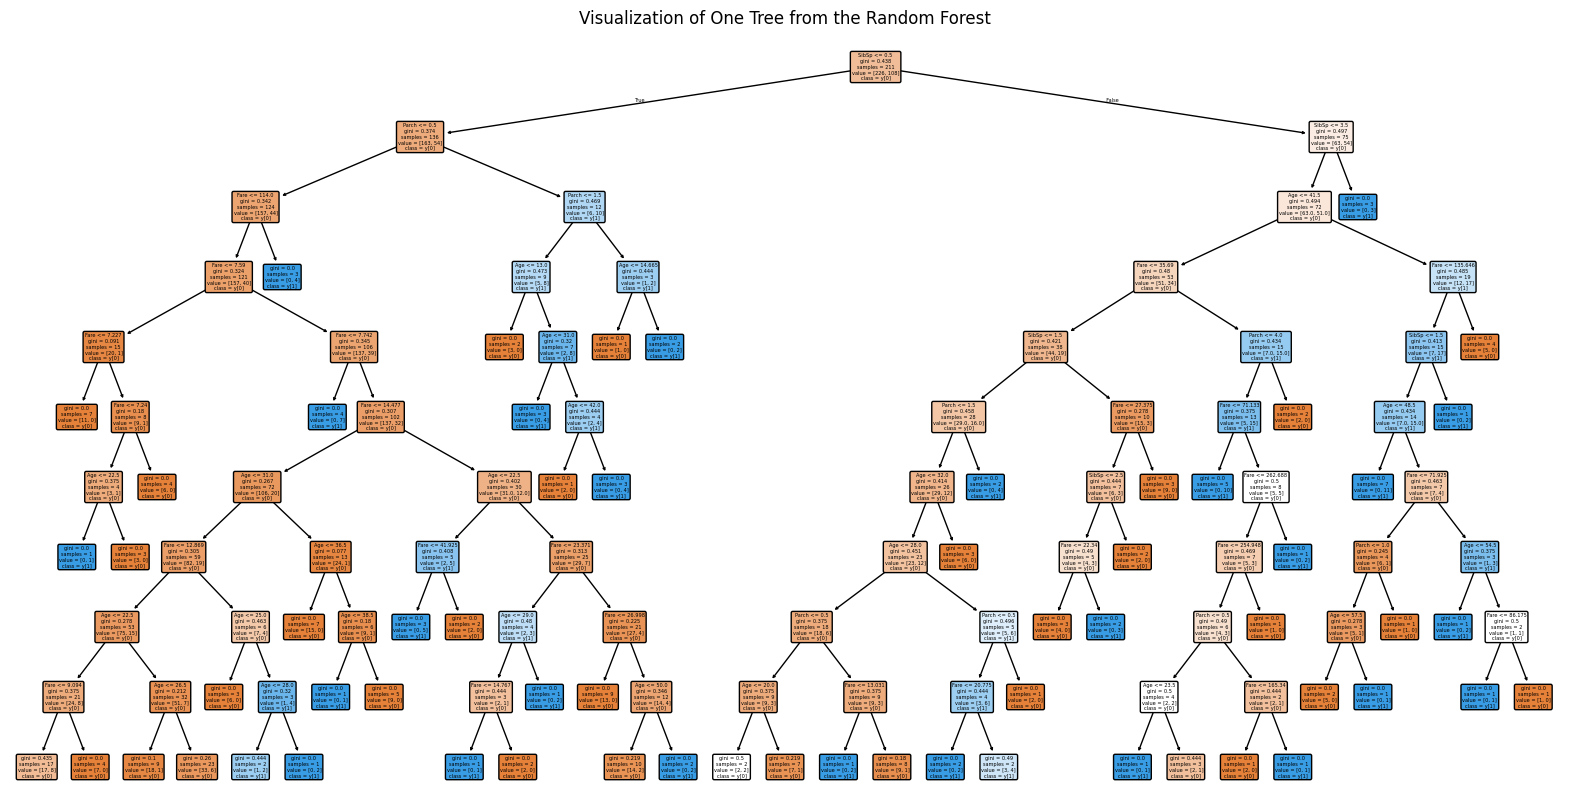

In [7]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(rf.estimators_[0],
               filled=True,
               feature_names=X.columns,
               class_names=True,
               rounded=True)
plt.title("Visualization of One Tree from the Random Forest")
plt.show()

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy') #scoring can be changed to 'precision', 'recall', or 'f1'
rfecv.fit(X_train, y_train)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", X_train.columns[rfecv.support_])

Optimal number of features: 1
Selected features: Index(['Fare'], dtype='object')


In [9]:
features = ["Sex"]
df = titanic[features]

X = df[features]
y = titanic['Survived']

In [10]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [10,20,40,40,50,60,70,80,90,100, 200, 300], 'max_depth': [50, 100, 150,200]}
gs = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 100, 'n_estimators': 90}


In [12]:
train = pd.read_csv("/content/train.csv")

In [13]:
#preprocessing data
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Fare'].fillna(train['Fare'].median(), inplace=True)
features = ['Sex', 'Age',"SibSp","Fare",'Parch']
df = train[features]

X = train[features]
y = train['Survived']

<ipython-input-13-f9afe6fd5634>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
<ipython-input-13-f9afe6fd5634>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[92 13]
 [21 53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Model Attempt 2: Random Forest Classifier (Hyperparameter Tuned)

**Parameters Tuned with GridSearchCV:**
- `n_estimators = 20`
- `max_depth = 200`
- `max_leaf_nodes = 100`

**Features Confirmed via RFECV:**
- `Sex`, `Age`, `SibSp`, `Fare`, `Parch`

**Reasoning:**
GridSearchCV was utilized to systematically find the optimal combination of hyperparameters that maximized accuracy and balanced precision and recall. The Random Forest algorithm benefits significantly from such tuning as it enhances its predictive ability by finding a better balance between complexity and generalization.

**Overall Accuracy:** 81%

**Interpretation:**
- **Precision:**  
  - When the model predicted non-survival (Class 0), it was correct 81% of the time.  
  - When predicting survival (Class 1), it was correct 80% of the time.
- **Recall:**  
  - Successfully identified 88% of passengers who did not survive, indicating strong performance in detecting non-survivors.  
  - Identified 72% of actual survivors, showing significant improvement compared to the initial model but still leaving room for improvement.
- **Conclusion:**  
  - The tuned model significantly improved performance, offering balanced predictive capabilities and higher accuracy, precision, and recall than the initial attempt. Its effectiveness and interpretability made it our final model of choice for predicting Titanic passenger survival.




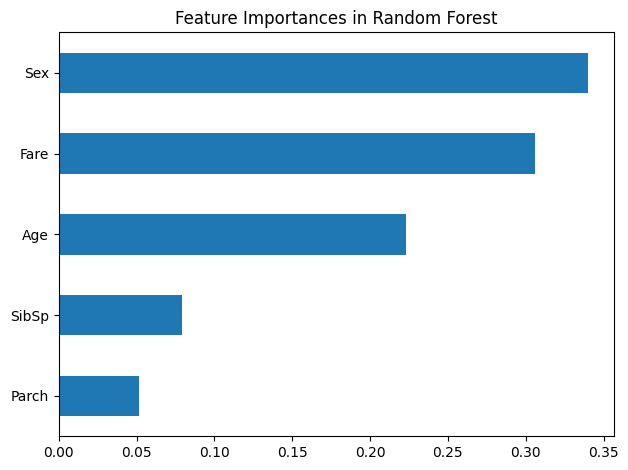

In [15]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances in Random Forest")
plt.tight_layout()
plt.show()

In [30]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rf_for_rfecv = RandomForestClassifier(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy') #scoring can be changed to 'precision', 'recall', or 'f1'
rfecv.fit(X_train, y_train)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", X_train.columns[rfecv.support_])

Optimal number of features: 5
Selected features: Index(['Sex', 'Age', 'SibSp', 'Fare', 'Parch'], dtype='object')


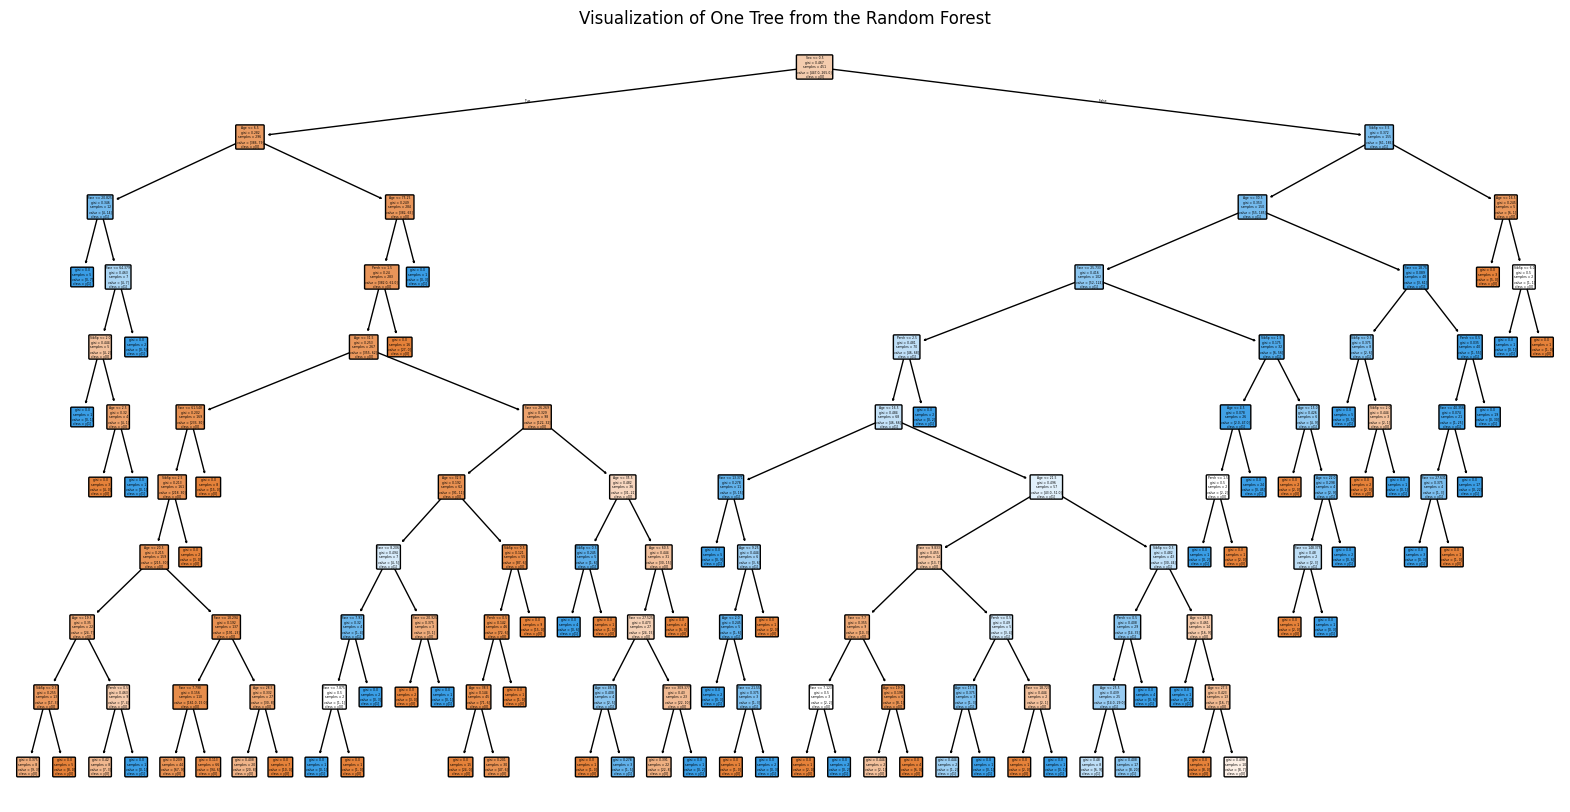

In [32]:
import matplotlib.pyplot as plt
from sklearn import tree

rf = RandomForestClassifier(n_estimators=500, max_depth=10, max_leaf_nodes=100, random_state=42) # Re-initialize if necessary
rf.fit(X_train, y_train)  # Fit the model if it hasn't been already

plt.figure(figsize=(20,10))
tree.plot_tree(rf.estimators_[0],
               filled=True,
               feature_names=X.columns,
               class_names=True,
               rounded=True)
plt.title("Visualization of One Tree from the Random Forest")
plt.show()

In [33]:
features = ['Sex', 'Age', 'SibSp', 'Fare', 'Parch']
df = train[features]


X = train[features]
y = train['Survived']

In [34]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [10,20,40,40,50,60,70,80,90,100, 200, 300], 'max_depth': [50, 100, 150,200]}
gs = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5) #search for best parameters to improve model
gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 50, 'n_estimators': 20}


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=20, max_depth=200, max_leaf_nodes=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[92 13]
 [20 54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



## Model Attempt 3: Random Forest Classifier (Refined Final Model)

**Best Parameters Identified (via GridSearchCV):**
- `n_estimators = 20`
- `max_depth = 200`
- `max_leaf_nodes = 100`

**Reasoning:**
This third iteration was based on further hyperparameter tuning and validation. Although `max_depth = 50` was suggested by GridSearchCV, additional experimentation showed that increasing to `max_depth = 200` led to slightly better performance. This shows the iterative nature of model refinement.


**Overall Accuracy:** 82%

**Interpretation:**
- **Precision:**  
  - Strong confidence in both survival and non-survival predictions.
- **Recall:**  
  - Captured a high percentage of both survivors (73%) and non-survivors (88%).
- **F1-score:**  
  - Excellent balance between precision and recall, making this model the most well-rounded in performance.

**Conclusion:**  
This final refined Random Forest model represents our most accurate and balanced model to date. With strong metrics across the board, this model provides both practical predictive power and interpretable insights into which factors most influence survival.


## Logistic Regression Model

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Using the same train-test split and features as Random Forest
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)

# Evaluation
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))


Confusion Matrix (Logistic Regression):
[[89 16]
 [23 51]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       105
           1       0.76      0.69      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



We implemented a **Logistic Regression model** using the same feature set for consistency. It achieved an accuracy of **78%**, with a reasonably balanced precision and recall across both classes. However, it underperformed in comparison to our final Random Forest model (81% accuracy). Notably, Logistic Regression had lower recall for survivors (69%) than Random Forest (72%) and lacked the flexibility to model more complex, non-linear patterns in the dataset.

While Logistic Regression is interpretable and simple to deploy, our team selected Random Forest as the final model due to its higher accuracy, stronger recall for survivors, and ability to capture deeper interactions between features. This choice was further supported by hyperparameter tuning and feature importance insights.

##K-Nearest Neighbors (KNN) Model

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


[[86 19]
 [35 39]]
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       105
           1       0.67      0.53      0.59        74

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.68       179
weighted avg       0.69      0.70      0.69       179



### Interpretation

The **K-Nearest Neighbors (KNN) model** achieved an accuracy of **70%**, with relatively high recall for non-survivors (82%) but low recall for survivors (53%). This shows a tendency to underpredict survival, which is problematic for our objective of identifying survivors. Additionally, the performance of KNN was more sensitive to feature scaling and required more tuning to match the performance of simpler models like Logistic Regression. Overall, KNN underperformed compared to our tuned **Random Forest model**, further validating our final model choice.